# Lab 5: Perceptual modeling

## References:

### Bark scale

### Critical bands

### Masking threshold in quiet

### Frequency masking

In [ ]:
!git clone https://github.com/xserra/audio-coding-materials.git
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io.wavfile import read
import scipy.signal as signal
from scipy.fftpack import fft, ifft

Cloning into 'audio-coding-materials'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 34 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 6.70 MiB | 16.61 MiB/s, done.
Resolving deltas: 100% (10/10), done.



## Part 1 - Bark Scale

explore the Bark scale.

In [ ]:
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

# Define the Bark scale conversion function
def hz2bark(f):
    """ Usage: Bark=hz2bark(f)
    f    : (ndarray)    Array containing frequencies in Hz.
    Returns  :
    Brk  : (ndarray)    Array containing Bark scaled values.
    """
    Brk = 6. * np.arcsinh(f/600.)
    return Brk

def bark2hz(Brk):
    """ Usage:
    Hz=bark2hs(Brk)
    Args     :
        Brk  : (ndarray)    Array containing Bark scaled values.
    Returns  :
        Fhz  : (ndarray)    Array containing frequencies in Hz.
    """

    Fhz = 600. * np.sinh(Brk/6.)
    return Fhz

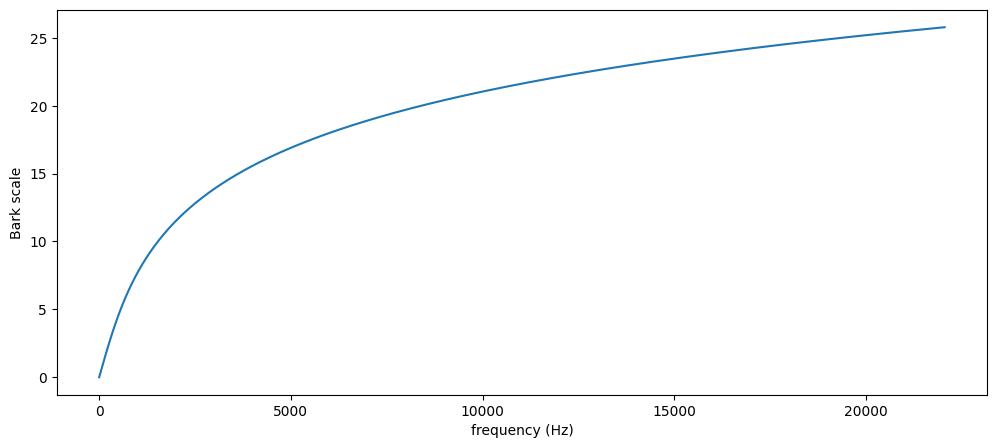

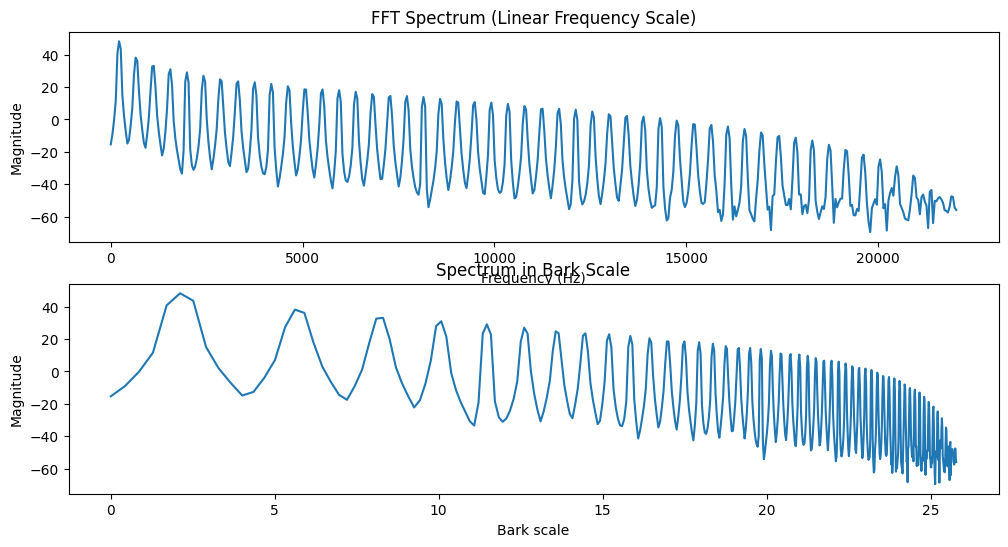

In [ ]:
# compute and plot the bark scale

freqs = np.linspace(0,22050,512)
bark_scale = hz2bark(freqs)

# Plot the Bark scale
plt.figure(figsize=(12, 5))
plt.plot(freqs, bark_scale)
plt.xlabel("frequency (Hz)")
plt.ylabel("Bark scale")

# plot the magnitude spectrum of a sound in the bark scale
x, fs = read_sound('/content/audio-coding-materials/synthetic.wav')
N = 1024
x1 = x[10000:10000+N]

# compute the hanning window
w = signal.get_window('hann', N)
# compute the spectrum of the windowed input signal
spectrum = fft(w*x1)
# compute the magnitude spectrum in dB
magnitude_spectrum = 20*np.log10(abs(spectrum[:N//2]))

# Plot the original FFT and the Bark scale spectrum
plt.figure(figsize=(12, 6))

bark_scale = hz2bark(freqs)

plt.subplot(2, 1, 1)
frequency_indexes =np.linspace(0,fs/2, N//2)
plt.plot(frequency_indexes, magnitude_spectrum)
plt.title("FFT Spectrum (Linear Frequency Scale)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")

plt.subplot(2, 1, 2)
plt.plot(bark_scale, magnitude_spectrum)
plt.title("Spectrum in Bark Scale")
plt.xlabel("Bark scale")
plt.ylabel("Magnitude")

plt.show()

**Questions:**

1. Compute and show the magnitude spectrum of a sound with different frequency axis, in particular, linear frequency, logarithmic frequency, and using the bark scale. Explain advantages and disadvantages of each one.

## Part 2 - Masking thrreshold of quiet

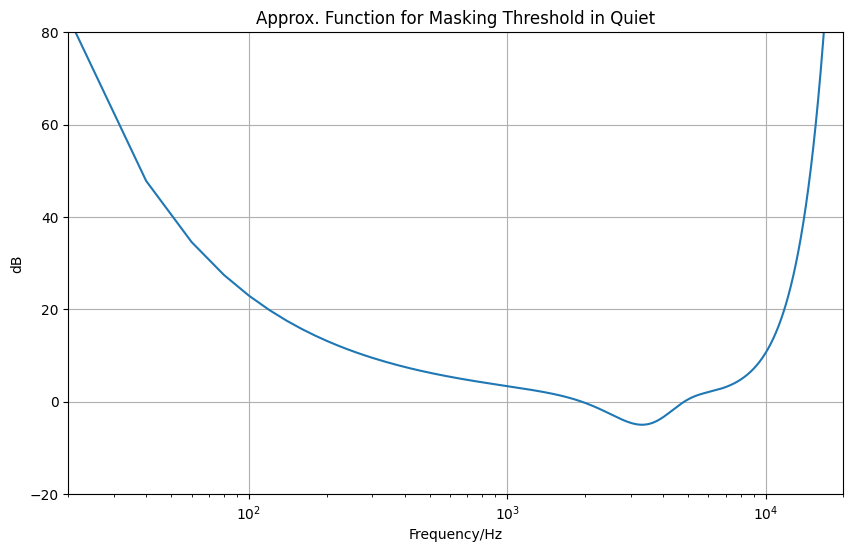

In [ ]:
# compute and display the the threshold curve of quiet

f=np.linspace(20,20000,1000)
LTQ=3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.-3.3)**2.)+1e-3*((f/1000.)**4.)
plt.figure(figsize=(10,6))
plt.semilogx(f,LTQ)
plt.axis([20,20000, -20,80])
plt.xlabel('Frequency/Hz')
plt.ylabel('dB')
plt.title('Approx. Function for Masking Threshold in Quiet')
plt.grid()

<ipython-input-6-434e7a1815f6>:5: RuntimeWarning: divide by zero encountered in power
  LTQ=np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.- 3.3)**2.)+1e-3*((f/1000.)**4.)),-20,60)


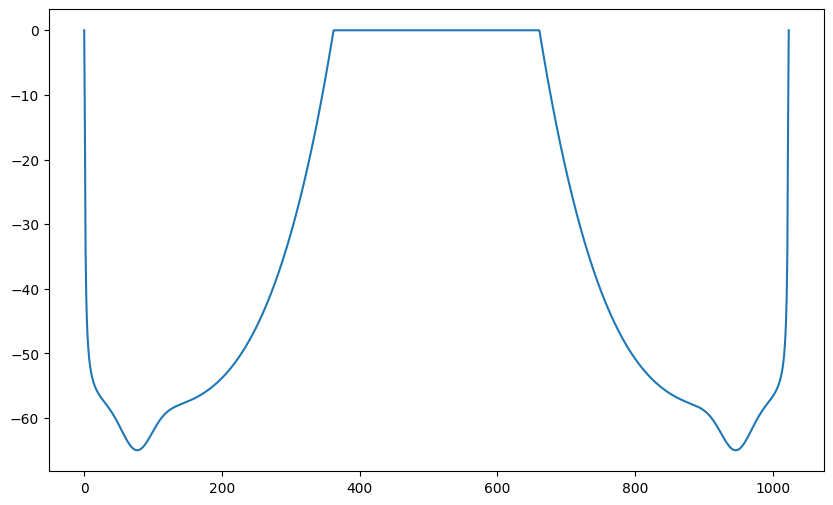

In [ ]:
# adapt the magnitude threshold of quiet to a curve to be used in a spectrum
fs = 44100    # sampling frequency
N = 1024      # number of subbands
f = np.linspace(0,fs/2, N//2)
LTQ=np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.- 3.3)**2.)+1e-3*((f/1000.)**4.)),-20,60)
LTQ=np.append(LTQ-60, np.flip(LTQ-60))
plt.figure(figsize=(10,6))
plt.plot(LTQ)

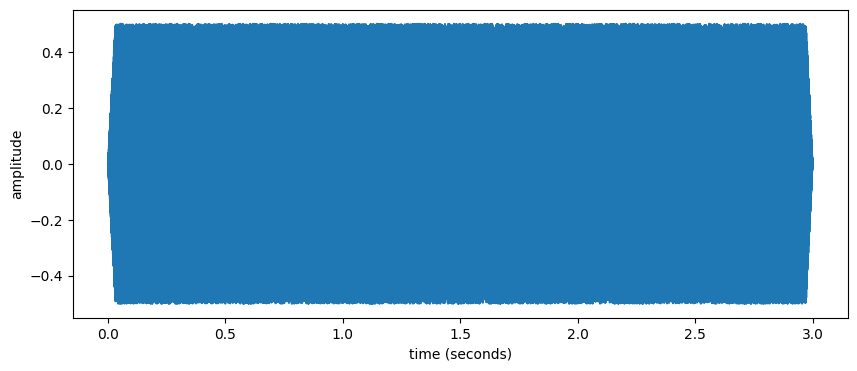

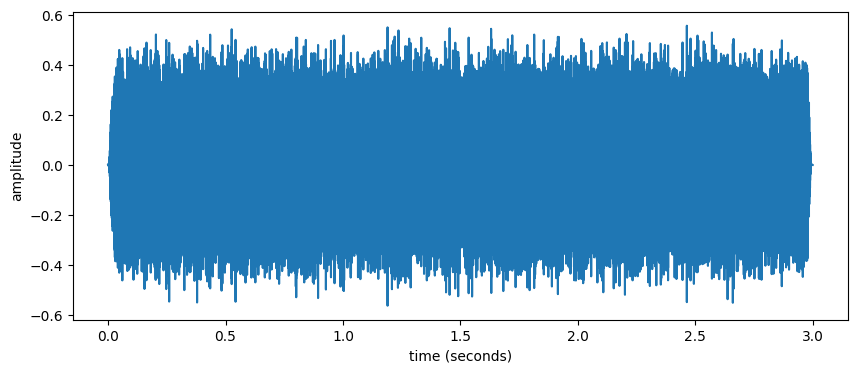

In [ ]:
# apply the masking curve of quiet to a sound

x, fs = read_sound('/content/audio-coding-materials/white-noise.wav')

y = np.zeros(len(x))
i = 0
while i < x.size-N:
  w = signal.get_window('hann', N)
  xw = x[i:i+N] * w
  X = fft(xw)
  mX = 20 * np.log10(abs(X))
  pX = np.angle(X)

  mX += LTQ
  Y = 10 ** (mX/20) * np.exp(1j * pX)
  yt = np.real(ifft(Y))
  y[i:i+N] += yt
  i += N//2

display_sound(x, fs)
display_sound(y, fs)

# Part 3 - Frequency masking

In [ ]:
def f_SP_dB(maxfreq,nfilts):
    #usage: spreadingfunctionmatdB=f_SP_dB(maxfreq,nfilts)
    #computes the spreading function protoype, in the Bark scale.
    #Arguments: maxfreq: half the sampling freqency
    #nfilts: Number of subbands in the Bark domain, for instance 64

    maxbark=hz2bark(maxfreq) #upper end of our Bark scale:22 Bark at 16 kHz

    #Number of our Bark scale bands over this range: nfilts=64
    spreadingfunctionBarkdB=np.zeros(2*nfilts)

    #Spreading function prototype, "nfilts" bands for lower slope
    spreadingfunctionBarkdB[0:nfilts]=np.linspace(-maxbark*27,-8,nfilts)-23.5

    #"nfilts" bands for upper slope:
    spreadingfunctionBarkdB[nfilts:2*nfilts]=np.linspace(0,-maxbark*12.0,nfilts)-23.5
    return spreadingfunctionBarkdB

def mapping2bark(mX,W,nfft):
    #Maps (warps) magnitude spectrum vector mX from DFT to the Bark scale
    #arguments: mX: magnitude spectrum from fft
    #W: mapping matrix from function mapping2barkmat
    #nfft: : number of subbands in fft
    #returns: mXbark, magnitude mapped to the Bark scale

    nfreqs= nfft//2

    #Here is the actual mapping, suming up powers and conv. back to Voltages:
    mXbark = (np.dot( np.abs(mX[:nfreqs])**2.0, W[:, :nfreqs].T))**(0.5)

    return mXbark

def mappingfrombark(mTbark,W_inv,nfft):
    #usage: mT=mappingfrombark(mTbark,W_inv,nfft)
    #Maps (warps) magnitude spectrum vector mTbark in the Bark scale
    # back to the linear scale
    #arguments:
    #mTbark: masking threshold in the Bark domain
    #W_inv : inverse mapping matrix W_inv from matrix W for mapping back from bark scale
    #nfft: : number of subbands in fft
    #returns: mT, masking threshold in the linear scale

    nfreqs = nfft//2
    mT = np.dot(mTbark, W_inv[:, :nfreqs].T)
    return mT

def maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha,fs,nfilts):
    #Computes the masking threshold on the Bark scale with non-linear superposition
    #usage: mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha)
    #Arg: mXbark: magnitude of FFT spectrum, on the Bark scale
    #spreadingfuncmatrix: spreading function matrix from function spreadingfunctionmat
    #alpha: exponent for non-linear superposition (eg. 0.6),
    #fs: sampling freq., nfilts: number of Bark subbands
    #nfilts: Number of subbands in the Bark domain, for instance 64
    #Returns: mTbark: the resulting Masking Threshold on the Bark scale

    #Compute the non-linear superposition:
    mTbark = np.dot(mXbark**alpha, spreadingfuncmatrix**alpha)

    #apply the inverse exponent to the result:
    mTbark = mTbark**(1.0/alpha)

    #Threshold in quiet:
    maxfreq = fs/2.0
    maxbark = hz2bark(maxfreq)
    step_bark = maxbark/(nfilts-1)
    barks=np.arange(0,nfilts)*step_bark

    #convert the bark subband frequencies to Hz:
    f=bark2hz(barks)+1e-6
    #Threshold of quiet in the Bark subbands in dB:
    LTQ=np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.-3.3)**2.)+1e-3*((f/1000.)**4.)),-20,160)
    #Maximum of spreading functions and hearing threshold in quiet:
    mTbark=np.max((mTbark, 10.0**((LTQ-60)/20)),0)
    return mTbark

def mapping2barkmat(fs, nfilts, nfft):
  #Constructing matrix W which has 1’s for each Bark subband, and 0’s else:
  #nfft=2048; nfilts=64;
  nfreqs=nfft//2
  maxfreq = fs/2.0
  maxbark = hz2bark(maxfreq)
  step_barks = maxbark/(nfilts-1)
  #the linspace produces an array with the fft band edges:
  binbarks = hz2bark(np.linspace(0,(nfft//2),(nfft//2)+1)*fs/nfft)
  W = np.zeros((nfilts, nfft))
  for i in range(nfilts):
    W[i,0:(nfft//2)+1] = (np.round(binbarks/step_barks)== i)
  return W

def mappingfrombarkmat(W,nfft):
    #Constructing inverse mapping matrix W_inv from matrix W for mapping back from bark scale
    #usuage: W_inv=mappingfrombarkmat(Wnfft)
    #argument: W: mapping matrix from function mapping2barkmat
    #nfft: : number of subbands in fft
    nfreqs=int(nfft/2)
    W_inv= np.dot(np.diag((1.0/np.sum(W,1))**0.5), W[:,0:nfreqs + 1]).T
    return W_inv

def spreadingfunctionmat(spreadingfunctionBarkdB,alpha,nfilts):
    #Turns the spreading prototype function into a matrix of shifted versions.
    #Convert from dB to "voltage" and include alpha exponent
    #nfilts: Number of subbands in the Bark domain, for instance 64
    spreadingfunctionBarkVoltage=10.0**(spreadingfunctionBarkdB/20.0*alpha)

    #Spreading functions for all bark scale bands in a matrix:
    spreadingfuncmatrix=np.zeros((nfilts,nfilts))

    for k in range(nfilts):
        spreadingfuncmatrix[k,:]=spreadingfunctionBarkVoltage[(nfilts-k):(2*nfilts-k)]

    return spreadingfuncmatrix

In [ ]:
# compute the frequency masking curve for each frame of a sound and subtract it from the sound
x, fs = read_sound('/content/audio-coding-materials/750340-background-music.wav')

maxfreq = fs/2
alpha = 0.8
nfilts = 64
N = 2048
W = mapping2barkmat(fs, nfilts, N)
W_inv = mappingfrombarkmat(W, N)
spreadingfunctionBarkdB=f_SP_dB(maxfreq,nfilts)
spreadingfuncmatrix=spreadingfunctionmat(spreadingfunctionBarkdB, alpha, nfilts)

y = np.zeros(len(x))
i = 0
while i < x.size-N:
  w = signal.get_window('hann', N)
  xw = x[i:i+N] * w
  X = fft(xw)
  mX = 20 * np.log10(abs(X))
  pX = np.angle(X)

  mXbark = mapping2bark(mX, W, N)
  # Compute the masking threshold in the Bark domain:
  mTbark =  maskingThresholdBark(mXbark, spreadingfuncmatrix, alpha, fs, nfilts)
  # Masking threshold in the original frequency domain
  mT = 20 * np.log10(mappingfrombark(mTbark, W_inv, N))
  masking_curve = np.append(mT, np.flip(mT[:N//2-1])) - 60
  masking_curve = np.clip(masking_curve,-50,0)
  mX += masking_curve
  plt.plot(mX)
  Y = 10 ** (mX/20) * np.exp(1j * pX)
  yt = np.real(ifft(Y))
  y[i:i+N] += yt
  i += N//2

display_sound(x, fs)
display_sound(y, fs)

Output hidden; open in https://colab.research.google.com to view.

**Questions:**

1. Apply the masking curve of quiet to a sound...